In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import load_model

from shared import read_dataset, plot_results, evaluate_price_predictions, mean_abs_error

2023-11-05 18:24:25.697320: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 18:24:25.726031: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 18:24:25.726070: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 18:24:25.726091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 18:24:25.731680: I tensorflow/core/platform/cpu_feature_g

In [14]:
start = "2010-01-01"
end = "2020-01-01"
target_column_name = 'Adj Close'
path_price_generator = '../models/lstm_model/price_generator.h5'
path_bidirectional = '../models/lstm_model/bidirectional.h5'
path_augmented_price = '../models/lstm_model/price_generator_plus_macro-vix.h5'

GS = read_dataset('../data/GS.csv', start, end)
vix = read_dataset('../data/vix.csv', start, end)
us_macro = read_dataset('../data/us_macro.csv', start, end)
commodities = read_dataset('../data/commodities.csv', start, end)
forex = read_dataset('../data/forex.csv', start, end)

GS['Close_Diff'] = GS['Close'].diff()
GS.dropna(inplace=True) # initially NAN for moving averages

data = pd.concat([
    us_macro,
    GS,
    vix
    ], axis=1)
data.dropna(inplace=True)

cols = [target_column_name] + [ col for col in GS if col != target_column_name]
target_column = list(GS.columns).index(target_column_name)
data = GS[cols]

print(f"#Trading Days: {data.shape}")

#Trading Days: (2496, 21)


#Trading Days: (2496, 21)

In [3]:
# Define feature array and target array to train the model.
data_array = np.array(data.values)
target_array = np.array(data[target_column_name].values).reshape(-1, 1)

# Normalize the data
scaler_data = MinMaxScaler()
scaler_data.fit(data_array)
data_array = scaler_data.transform(data_array)

scaler_target = MinMaxScaler()
scaler_target.fit(target_array)
target_array = scaler_target.transform(target_array)

# Split the data
train_size = int(len(data_array) * 0.70)
evaluation_size = int(len(data_array) * 0.0) # no evaluation

def create_sequences(data, target, seq_length):
    sequence_data = []
    sequence_target = []
    for i in range(seq_length, len(data)):
        sequence_data.append(data[i-seq_length:i])
        sequence_target.append(target[i])
    return np.array(sequence_data), np.array(sequence_target)

SEQUENCE_LENGTH = 17
data_sequences, target_sequences = create_sequences(data_array, target_array, SEQUENCE_LENGTH)

train_data, eval_data, test_data = data_sequences[:train_size], data_sequences[train_size:train_size+evaluation_size], data_sequences[train_size+evaluation_size:]
train_target, eval_target, test_target = target_sequences[:train_size], target_sequences[train_size:train_size+evaluation_size], target_sequences[train_size+evaluation_size:]

In [4]:
# TESTING CORRECTNESS OF GENERATED SEQUENCES
test_index = -1
a = scaler_data.inverse_transform(data_sequences[test_index])
b = scaler_target.inverse_transform(target_sequences)

for i in range (0, 17):
    print(f"A[{i}]: {a[i][0]}")

print(f'b: {b[test_index]}')

A[0]: 198.3981170654297
A[1]: 205.22335815429688
A[2]: 202.6650238037109
A[3]: 202.7289886474609
A[4]: 202.0985565185547
A[5]: 206.53907775878903
A[6]: 205.5797119140625
A[7]: 208.3572998046875
A[8]: 211.1988677978516
A[9]: 210.55931091308602
A[10]: 210.09330749511722
A[11]: 209.1705017089844
A[12]: 209.31668090820312
A[13]: 210.0659027099609
A[14]: 211.2537078857422
A[15]: 210.7511749267578
A[16]: 209.9653778076172
b: [210.08416748]


In [9]:
def build_model():
    """LSTM model"""
    model = keras.Sequential()
    model.add(keras.layers.LSTM(100, input_shape=(train_data.shape[1], train_data.shape[2]), return_sequences=False))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units=1))
    return model

def build_bidirectional_lstm():
    """
    Bidirectional LSTM model
    --
    Result: does not improve performance.
    """
    model = keras.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, input_shape=(train_data.shape[1], train_data.shape[2]))))
    model.add(keras.layers.Dense(1))
    return model

def train_model(model, train_data, train_target, epochs=30, batch_size=256):
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_data, train_target, epochs=epochs, batch_size=batch_size, verbose=2)

In [10]:
epochs = 300
batch_size = 256

## GENERATE MODEL ##
model = build_model()
train_model(model, train_data, train_target, epochs=epochs, batch_size=batch_size)
# model.save(path_bidirectional)

## LOAD MODEL ##
# model = load_model(path_price_generator)

Epoch 1/300
7/7 - 1s - loss: 0.1149 - 1s/epoch - 144ms/step
Epoch 2/300
7/7 - 0s - loss: 0.0182 - 110ms/epoch - 16ms/step
Epoch 3/300
7/7 - 0s - loss: 0.0171 - 125ms/epoch - 18ms/step
Epoch 4/300
7/7 - 0s - loss: 0.0082 - 130ms/epoch - 19ms/step
Epoch 5/300
7/7 - 0s - loss: 0.0065 - 139ms/epoch - 20ms/step
Epoch 6/300
7/7 - 0s - loss: 0.0056 - 126ms/epoch - 18ms/step
Epoch 7/300
7/7 - 0s - loss: 0.0047 - 110ms/epoch - 16ms/step
Epoch 8/300
7/7 - 0s - loss: 0.0045 - 111ms/epoch - 16ms/step
Epoch 9/300
7/7 - 0s - loss: 0.0040 - 112ms/epoch - 16ms/step
Epoch 10/300
7/7 - 0s - loss: 0.0041 - 125ms/epoch - 18ms/step
Epoch 11/300
7/7 - 0s - loss: 0.0038 - 123ms/epoch - 18ms/step
Epoch 12/300
7/7 - 0s - loss: 0.0035 - 125ms/epoch - 18ms/step
Epoch 13/300
7/7 - 0s - loss: 0.0032 - 119ms/epoch - 17ms/step
Epoch 14/300
7/7 - 0s - loss: 0.0033 - 115ms/epoch - 16ms/step
Epoch 15/300
7/7 - 0s - loss: 0.0033 - 117ms/epoch - 17ms/step
Epoch 16/300
7/7 - 0s - loss: 0.0030 - 116ms/epoch - 17ms/step
Epo

23/23 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 20.67


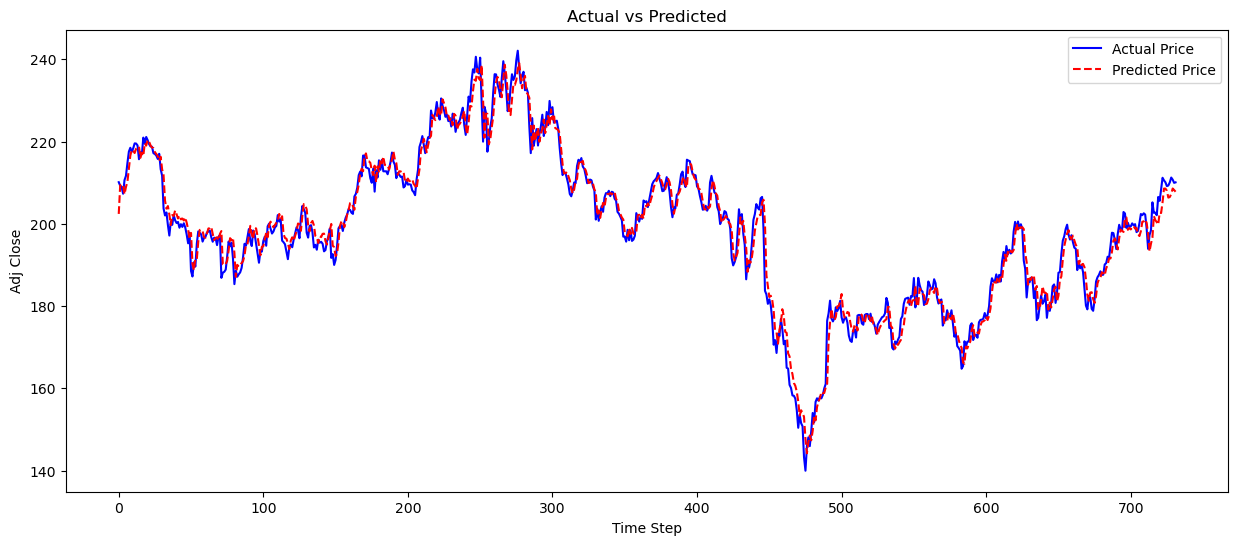

In [11]:
# TESTing: DENORMALIZE TARGET AND PREDICTIONS ##
price_predicted_array = scaler_target.inverse_transform(model.predict(test_data))
price_actual_array = scaler_target.inverse_transform(test_target).flatten()

## PLOTting #
plot_results(price_actual_array, price_predicted_array, target_column_name)

In [12]:
evaluate_price_predictions(scaler_target.inverse_transform(model.predict(test_data)).flatten(), scaler_target.inverse_transform(test_target).flatten())

23/23 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 2.31
Mean Squared Error (MSE): 9.55
Root Mean Squared Error (RMSE): 3.09
Mean Absolute Percentage Error (MAPE): 1.18%
R-squared (R²): 0.97


# First results
The model overall is great.
It gets the tends and a mean absolute percentage error of 1.28% is not bad to make general predictions.

But probably not for trading. Let's try to get it better: can I filter out some predictions?

### Assumption:
- I don't need it to be accurate 100% of the times

Let's try to assess how much the model is sure about the prediction it is doing.

## 1st try
I added a dropout layer in the end to try to calculate a standard deviation on the model.
- The correlation between the error and the standard deviation is almost 0, it is not working.


23/23 [==============================] - 0s 2ms/step


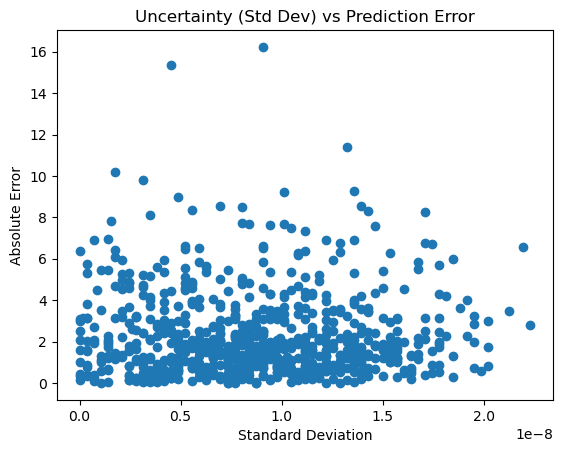

Correlation coefficient between standard deviation and absolute error: -0.007738031905397473


In [13]:
def predict_with_mc_dropout(model, data, num_samples=100):
    model.trainable = True 
    predictions = np.array([model.predict(data) for _ in range(num_samples)])
    mean_predictions = predictions.mean(axis=0).flatten()
    std_predictions = predictions.std(axis=0).flatten()
    return mean_predictions, std_predictions

predictions_array, pred_std_array = predict_with_mc_dropout(model, test_data, num_samples=300)

# Denormalize predictions and standard deviations
predictions_denorm = scaler_target.inverse_transform(predictions_array.reshape(-1, 1)).flatten()
std_devs_denorm = pred_std_array * scaler_target.scale_

errors = np.abs(predictions_denorm - price_actual_array)

plt.scatter(std_devs_denorm, errors)
plt.xlabel('Standard Deviation')
plt.ylabel('Absolute Error')
plt.title('Uncertainty (Std Dev) vs Prediction Error')
plt.show()

correlation_coef = np.corrcoef(std_devs_denorm, errors)[0, 1]
print(f'Correlation coefficient between standard deviation and absolute error: {correlation_coef}')

In [ ]:
model.save(path_augmented_price)
